# Introduction to PyTorch 

Image classification with LeNet-5 architecture using the CIFAR10 dataset.

Original tutorial: [Introduction to PyTorch](https://pytorch.org/tutorials/beginner/introyt/introyt1_tutorial.html)

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import numpy as np

plt.style.use('seaborn-v0_8')

In [24]:
# Define LeNet-5 model

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [25]:
# Load the CIFAR-10 data

DATA_DIR = '../data'

CLASSES = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5),
    )
])

train_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform,
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform,
)

batch_size = 64

torch.manual_seed(42)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


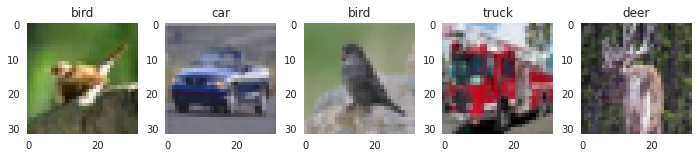

In [33]:
# Visualize some data

x, y = next(iter(train_dataloader))

def display_image(x):
    img = x / 2 + 0.5
    img = np.transpose(img.numpy(), (1, 2, 0))
    return img

fig, ax = plt.subplots(1, 5, figsize=(12, 2), dpi=72)
for i in range(5):
    ax[i].set_title(CLASSES[y[i]])
    ax[i].imshow(display_image(x[i]))
    ax[i].grid(False)

In [27]:
# Train the model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LeNet().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(model, dataloader, loss_fn, optimizer):
    train_loss, train_acc, count = 0, 0, 0

    model.train()
    for x_train, y_train in dataloader:
        x_train, y_train = x_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        prediction = torch.max(y_pred, 1)[1]
        train_acc += (prediction == y_train).sum()
        train_loss += loss
        count += len(y_train)

    return train_acc.item()/count, train_loss.item()/count


def validate(model, dataloader, loss_fn):
    val_loss, val_acc, count = 0, 0, 0
    model.eval()

    with torch.no_grad():
        for x_val, y_val in dataloader:
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_pred = model(x_val)
            loss = loss_fn(y_pred, y_val)

            prediction = torch.max(y_pred, 1)[1]
            val_acc += (prediction == y_val).sum()
            val_loss += loss
            count += len(y_val)

    return val_acc.item()/count, val_loss.item()/count


history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
epochs = 50
for epoch in range(epochs):
    train_acc, train_loss = train(model, train_dataloader, loss_fn, optimizer)
    val_acc, val_loss = validate(model, test_dataloader, loss_fn)
    history['train_acc'] += [train_acc]
    history['train_loss'] += [train_loss]
    history['val_acc'] += [val_acc]
    history['val_loss'] += [val_loss]

    if epoch == 0 or (epoch+1) % 5 == 0:
        print(
            f'Epoch {epoch+1:2}: train acc = {train_acc:.2f}, train loss = {train_loss:.2f}, '
            f'val acc = {val_acc:.2f}, val loss = {val_loss:.2f}'
        )

print('Training completed.')

Epoch  1: train acc = 0.15, train loss = 0.04, val acc = 0.24, val loss = 0.03
Epoch  5: train acc = 0.42, train loss = 0.02, val acc = 0.44, val loss = 0.02
Epoch 10: train acc = 0.54, train loss = 0.02, val acc = 0.55, val loss = 0.02
Epoch 15: train acc = 0.60, train loss = 0.02, val acc = 0.59, val loss = 0.02
Epoch 20: train acc = 0.64, train loss = 0.02, val acc = 0.62, val loss = 0.02
Epoch 25: train acc = 0.67, train loss = 0.01, val acc = 0.63, val loss = 0.02
Epoch 30: train acc = 0.69, train loss = 0.01, val acc = 0.65, val loss = 0.02
Epoch 35: train acc = 0.71, train loss = 0.01, val acc = 0.65, val loss = 0.02
Epoch 40: train acc = 0.74, train loss = 0.01, val acc = 0.66, val loss = 0.02
Epoch 45: train acc = 0.76, train loss = 0.01, val acc = 0.66, val loss = 0.02
Epoch 50: train acc = 0.77, train loss = 0.01, val acc = 0.66, val loss = 0.02
Training completed.


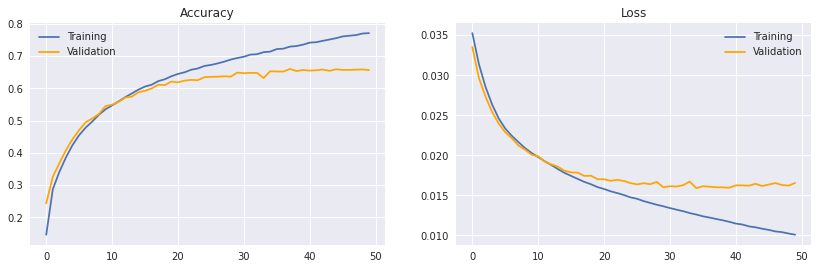

In [34]:
plt.figure(figsize=(14,4), dpi=72)

plt.subplot(121)
plt.plot(history['train_acc'], label='Training')
plt.plot(history['val_acc'], label='Validation', color='orange')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history['train_loss'], label='Training')
plt.plot(history['val_loss'], label='Validation', color='orange')
plt.title('Loss')
plt.legend()

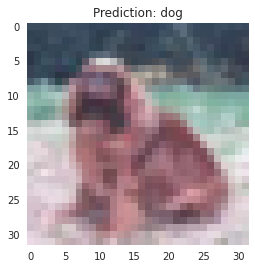

In [96]:
# Using the model 

x_test, y_test = test_dataset[101]

plt.figure(figsize=(4,4), dpi=72)
plt.imshow(display_image(x_test))

model.eval()
with torch.no_grad():
    x_test = torch.unsqueeze(x_test, 0)
    y_test = model(x_test)
    pred = torch.max(y_test, 1)[1]

plt.title(f'Prediction: {CLASSES[pred.item()]}')
plt.grid(False)